# Download and extract data

In [1]:
# Clone necessary files
!git clone https://github.com/ichatnun/MCI-multiple-drawings-PyTorch.git
!mv MCI-multiple-drawings-PyTorch/* .
!rm -r MCI-multiple-drawings-PyTorch sample_data

# Create the data folder: 'MCI-multiple-drawings-PyTorch/data'
!mkdir data/multiDrawingMCI2022

# Download the data and corresponding labels
!wget -P data/multiDrawingMCI2022/ https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
!wget -O images.zip https://github.com/cccnlab/MCI-multiple-drawings/raw/main/images.zip
!unzip -q images.zip -d data/multiDrawingMCI2022/
!rm images.zip

Cloning into 'MCI-multiple-drawings-PyTorch'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 88 (delta 31), reused 66 (delta 16), pack-reused 0
Receiving objects: 100% (88/88), 77.25 KiB | 5.15 MiB/s, done.
Resolving deltas: 100% (31/31), done.
mkdir: cannot create directory ‘data/multiDrawingMCI2022’: No such file or directory
--2023-09-19 04:07:26--  https://github.com/cccnlab/MCI-multiple-drawings/raw/main/label.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv [following]
--2023-09-19 04:07:27--  https://raw.githubusercontent.com/cccnlab/MCI-multiple-drawings/main/label.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133

# Import necessary modules

In [2]:
import sys, os
import numpy as np
import torch

import matplotlib.pyplot as plt

from dataloader.getDataloaders import getDataloaders
from utils.utils import testDataloader

# Specify parameters

In [3]:
# Create a dictionary to store additional info
add_info = {'dataset_name': 'multiDrawingMCI',
            'idx2class_dict': {'0': 'control', '1': 'mci'},
            'healthy_threshold': 25, # MoCA score of >= 25-> healthy
            'batch_size': 64}
add_info['class_list'] = [add_info['idx2class_dict'][key] for key in add_info['idx2class_dict'].keys()]
add_info['num_classes'] = len(add_info['idx2class_dict'].keys())

# Available tasks: 'clock', 'copy', 'trail'
add_info['task_list'] = ['clock', 'copy', 'trail']

# Create the results folder
add_info['results_dir'] = os.path.join(os.getcwd(), 'results')
os.makedirs(add_info['results_dir'], exist_ok=True)

In [4]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = AttributeDict()
args.val_fraction = 0.15
args.test_fraction = 0.15
args.random_seed = 28
args.label_type = 'hard' # Available options: 'raw', 'hard', 'soft'
args.use_pretrained_weight = False

## Check arguments

In [5]:
# Check val and test fractions
if args.val_fraction + args.test_fraction >= 1:
    print('Invalid training fraction')
    sys.exit(1)

# Create training, validation, and test DataLoaders

In [6]:
dataloader_dict = getDataloaders(args, add_info)

# Test one of the created DataLoaders using the provided function

It gets a sample batch and saves the images and corresponding labels in the 'results' folder

*   test_loader_sample_data_batch.png
*   test_loader_sample_label_batch.csv



The clock data are in the range (0.0, 1.0)
The copy data are in the range (0.0, 1.0)
The trail data are in the range (0.0, 1.0)


<Figure size 800x800 with 0 Axes>

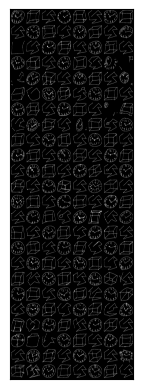

In [7]:
testDataloader(dataloader_dict['test'],
                add_info['results_dir'],
                add_info['batch_size'],
                add_info['task_list'])

# Try getting a batch from the training DataLoader manually

In [8]:
curr_data_batch, curr_label_batch = next(iter(dataloader_dict['train']))
labels = curr_label_batch

## Extract some information from the batch

****************** clock ******************
Data: torch.Size([64, 3, 256, 256])
Labels: torch.Size([64, 2])
The R, G, and B channels are identical


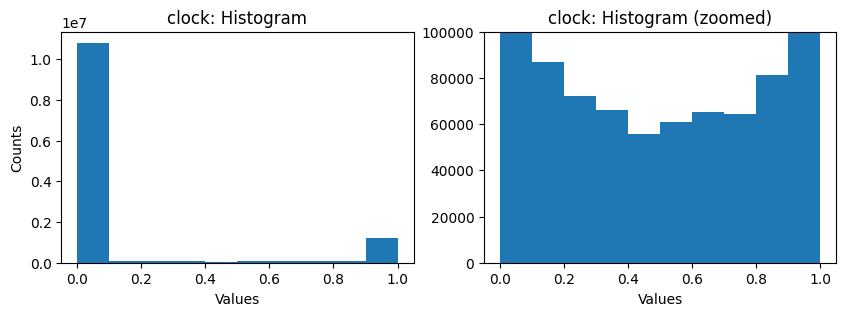

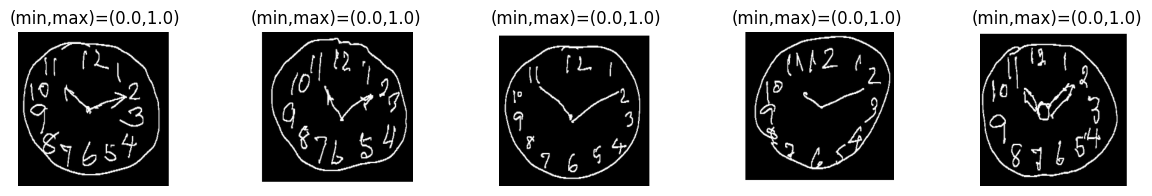



****************** copy ******************
Data: torch.Size([64, 3, 256, 256])
Labels: torch.Size([64, 2])
The R, G, and B channels are identical


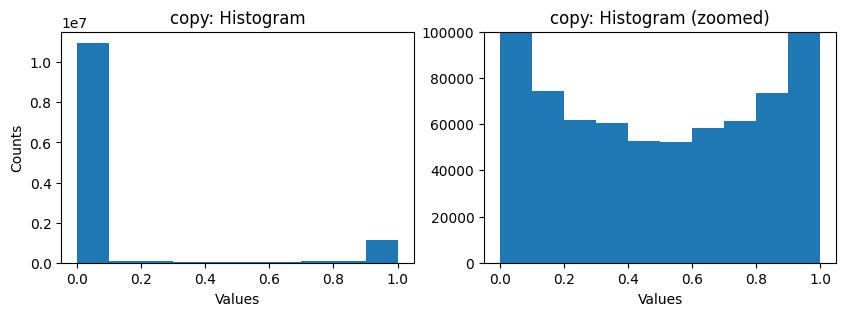

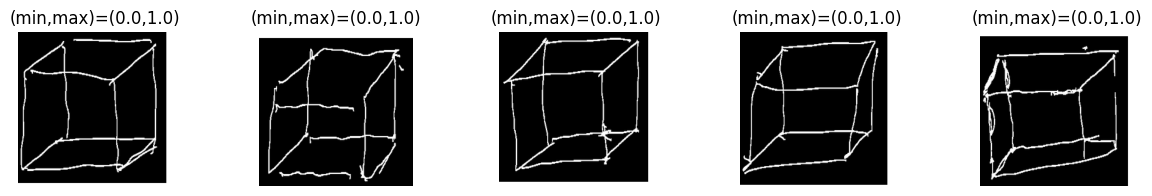



****************** trail ******************
Data: torch.Size([64, 3, 256, 256])
Labels: torch.Size([64, 2])
The R, G, and B channels are identical


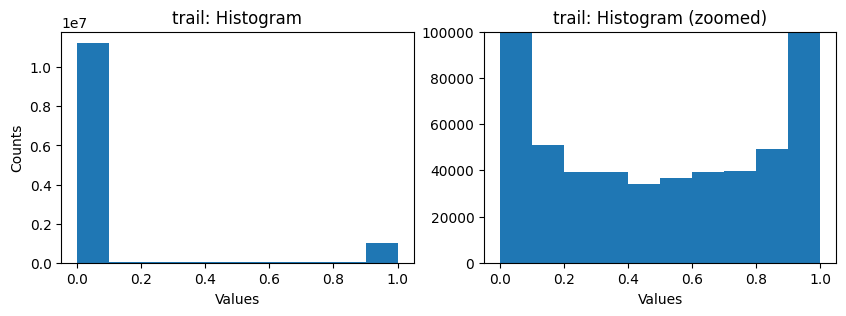

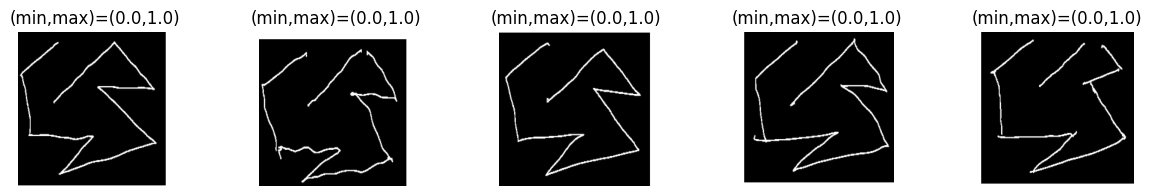

In [9]:
# Specify # of images to be displayed (per task)
num_display_imgs = min(5, add_info['batch_size'])

for curr_task in add_info['task_list']:

    print(f"****************** {curr_task} ******************")
    # Extract the data from the first task (given by add_info['task_list'][0])
    data_one_task = curr_data_batch[curr_task]

    # Check the dimensions
    print(f"Data: {data_one_task.shape}")
    print(f"Labels: {labels.shape}")

    # Check if the R, G, and B channels are identical
    is_rg_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 1, :, :])
    is_rb_equal = torch.equal(data_one_task[:, 0, :, :], data_one_task[:, 2, :, :])
    is_gb_equal = torch.equal(data_one_task[:, 1, :, :], data_one_task[:, 2, :, :])

    if is_rg_equal and is_rb_equal and is_gb_equal:
        print("The R, G, and B channels are identical")
    else:
        print("The R, G, and B channels contain different values")

    # Plot the histogram of the pixel values
    data_flatten = data_one_task.numpy().reshape(-1,)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(data_flatten)
    plt.ylabel('Counts')
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram")

    plt.subplot(1, 2, 2)
    plt.hist(data_flatten)
    plt.ylim(0, 1e5)
    plt.xlabel('Values')
    plt.title(f"{curr_task}: Histogram (zoomed)")

    # Display the first five images of each task in the batch
    plt.figure(figsize=(num_display_imgs*3, 2))
    for idx_img in range(num_display_imgs):

        # Extract an image
        curr_img = data_one_task.numpy()[idx_img].transpose(1, 2, 0)

        # Plot the image
        plt.subplot(1, num_display_imgs, idx_img + 1)
        plt.imshow(curr_img)
        plt.title(f"(min,max)=({np.min(curr_img)},{np.max(curr_img)})")
        plt.axis('off')

    plt.show()
    print("\n")